Cosmo MCMC is landing on biased HOD + Cosmology. I'm gonna first look at the code to make preds, and compare to the emulator. 

In [14]:
from pearce.emulator import OriginalRecipe, ExtraCrispy, SpicyBuffalo
from pearce.mocks import cat_dict
import numpy as np
from os import path

In [15]:
import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [16]:
training_file = '/scratch/users/swmclau2/xi_zheng07_cosmo_lowmsat/PearceRedMagicXiCosmoFixedNd.hdf5'
test_file = '/scratch/users/swmclau2/xi_zheng07_cosmo_test_lowmsat/PearceRedMagicXiCosmoFixedNd_Test.hdf5'

#test_file = '/u/ki/swmclau2/des/xi_cosmo_tester/PearceRedMagicXiCosmoFixedNd_test.hdf5'
em_method = 'gp'
split_method = 'random'

In [17]:
a = 1.0
z = 1.0/a - 1.0

In [18]:
fixed_params = {'z':z}#, 'cosmo': 3}#, 'r':0.53882047}

In [19]:
np.random.seed(0)
emu = SpicyBuffalo(training_file, method = em_method, fixed_params=fixed_params,
                 custom_mean_function = 'linear', downsample_factor = 0.1)

40000 18


In [20]:
emu.downsample_x[0]

array([[ 0.25505943, -1.06774736,  1.12812633, ...,  1.32824196,
        -1.30730569, -0.61128628],
       [-1.22755426, -0.28587034,  0.79496373, ..., -0.97484581,
         0.45280527, -0.57318286],
       [ 0.25118492, -0.08194602, -0.66044351, ...,  1.36980144,
         1.02795964, -1.62968685],
       ..., 
       [-0.49052942, -0.09342656, -0.5888257 , ...,  0.25808539,
        -0.31291229, -1.15166209],
       [ 0.25505943, -1.06774736,  1.12812633, ..., -1.69867339,
        -1.54984066, -1.31793158],
       [ 1.8068932 , -0.09445741,  0.62761446, ...,  1.60876844,
        -1.21722127,  1.45669039]])

In [21]:
emu.get_param_names()

['ombh2',
 'omch2',
 'w0',
 'ns',
 'ln10As',
 'H0',
 'Neff',
 'logM0',
 'sigma_logM',
 'logM1',
 'alpha']

In [22]:
v = np.ones_like(emu._emulators[0].get_parameter_vector())*12.0

In [23]:
if hasattr(emu, "_emulator"):
    emu._emulator.set_parameter_vector(v)
    emu._emulator.recompute()
else:
    for _emulator in emu._emulators:
        _emulator.set_parameter_vector(v)
        _emulator.recompute()

In [24]:
emu._emulators[0].get_parameter_vector()

array([ 12.,  12.,  12.,  12.,  12.,  12.,  12.,  12.,  12.,  12.,  12.,
        12.,  12.,  12.,  12.,  12.,  12.,  12.,  12.,  12.,  12.,  12.,
        12.,  12.,  12.])

In [25]:
gof = emu.goodness_of_fit(test_file, statistic='log_frac')

In [26]:
for g in gof:
    print np.mean(g), np.median(g)

0.0166637564266 0.0153943204176
0.0159135775874 0.0143586504424
0.0150881172738 0.0136572802046
0.0156568550658 0.014578439827
0.0137700129004 0.012948652029
0.0119548836086 0.0107203434047
0.0105614808591 0.00903365744858
0.00997102096228 0.00837985671523
0.0116328008408 0.0100816669693
0.0152521001372 0.0137610926042
0.0213306791916 0.0202543833186
0.0221083636758 0.0187472061078
0.0253729778295 0.0230421535435
0.0347401011195 0.0311599943042
0.0826807374455 0.0656086601807
0.269473594369 0.0824457394676
0.552182681116 0.0299442841845
0.0723637117784 0.0217388539732


In [27]:
params = {}
for pname in emu.get_param_names():
    if pname == 'r':
        continue
    low, high = emu.get_param_bounds(pname)
    params[pname] = np.random.uniform(low, high)
    
print params

{'logM1': 13.877363939148976, 'Neff': 3.1432558979019003, 'logM0': 14.172280226504418, 'sigma_logM': 0.20567381187952294, 'H0': 73.81017903204182, 'w0': -0.8336176771617664, 'omch2': 0.1169921822497212, 'ln10As': 3.0310178918831787, 'alpha': 1.1845438159554034, 'ns': 0.977517190116882, 'ombh2': 0.021033331192341943}


In [28]:
fixed_params = {}#'f_c':1.0}#,'logM1': 13.8 }# 'z':0.0}

cosmo_params = {'simname':'testbox', 'boxno': 3, 'realization': 0, 'scale_factors':[1.0], 'system': 'sherlock'}
cat = cat_dict[cosmo_params['simname']](**cosmo_params)#construct the specified catalog!

In [29]:
cat.load(1.0, HOD='zheng07')

In [30]:
print len(cat.halocat.halo_table)

9547354


In [31]:
cat._get_cosmo_param_names_vals()[1]

array([  2.17629000e-02,   1.22830000e-01,  -1.13151000e+00,
         9.53515000e-01,   3.11395000e+00,   7.07317000e+01,
         3.70000000e+00])

In [32]:
test_point_idx = 1
test_point_dict = dict(zip(emu.get_param_names(), emu.x[0][test_point_idx]*emu._x_std[0]+emu._x_mean[0]))

In [33]:
#hod_param_names = ['logM0', 'sigma_logM', 'logM1', 'alpha']
emulation_point = [('logM0', 14.0), ('sigma_logM', 0.2),
                    ('alpha', 1.083),('logM1', 13.7)]#, ('logMmin', 12.233)]

#em_params = {key:test_point_dict[key] for key in hod_param_names}
#em_params = dict(zip(hod_param_names, x_point))
em_params = dict(emulation_point)
em_params.update(fixed_params)

In [34]:
from scipy.optimize import minimize_scalar
def add_logMmin(hod_params, cat, nd = 1e-4):
    """
    In the fixed number density case, find the logMmin value that will match the nd given hod_params
    :param: hod_params:
        The other parameters besides logMmin
    :param cat:
        the catalog in question
    :return:
        None. hod_params will have logMmin added to it.
    """
    hod_params['logMmin'] = 13.0 #initial guess
    #cat.populate(hod_params) #may be overkill, but will ensure params are written everywhere
    def func(logMmin, hod_params):
        hod_params.update({'logMmin':logMmin})
        calc_nd = cat.calc_analytic_nd(hod_params)
        #print logMmin, calc_nd
        return (calc_nd - nd)**2

    res = minimize_scalar(func, bounds = (12, 16), args = (hod_params,), options = {'maxiter':100}, method = 'Bounded' )
    # assuming this doens't fail
    hod_params['logMmin'] = res.x


In [35]:
add_logMmin(em_params, cat)

In [36]:
r_bins = np.logspace(-1.1, 1.6, 19)
rpoints = (r_bins[1:]+r_bins[:-1])/2.0

In [37]:
em_params['logMmin']

13.401595794926763

In [38]:
_xi_vals = []
for i in xrange(5):
    cat.populate(em_params, min_ptcl=100)
    _xi_vals.append(cat.calc_xi(r_bins))

In [39]:
xi_vals = np.log10(np.array(_xi_vals))
y_calc = xi_vals.mean(axis = 0) #take one example as our xi. could also use the mean, but lets not cheat.
cov = np.cov(xi_vals.T)#/np.sqrt(50)

In [40]:
print em_params

{'logMmin': 13.401595794926763, 'logM1': 13.7, 'logM0': 14.0, 'sigma_logM': 0.2, 'alpha': 1.083}


In [41]:
# get cosmo params
try:
    del em_params['logMmin']
except KeyError:
    pass
cpv = cat._get_cosmo_param_names_vals()

cosmo_param_dict = {key: val for key, val in zip(cpv[0], cpv[1])}

em_params.update( cosmo_param_dict)


In [42]:
y_pred = emu.emulate_wrt_r(em_params)[0]

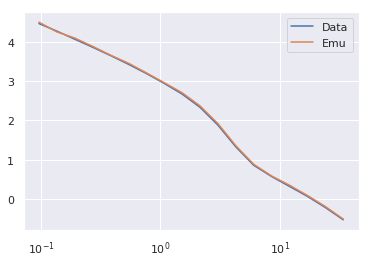

In [43]:
#plt.plot(emu.scale_bin_centers, xi_vals.T, alpha = 0.4)
plt.plot(emu.scale_bin_centers, y_calc, label = 'Data')
plt.plot(emu.scale_bin_centers, y_pred, label = 'Emu')

plt.legend(loc='best')
plt.xscale('log')

In [44]:
fixed_params = {'z':z, 'cosmo': 3}#, 'r':0.53882047}
train_x, train_y, _, info = emu.get_data(test_file, fixed_params, None)#, skip_nans = False)

In [45]:
info

{'n_bins': 18,
 'obs': 'xi',
 'ordered_params': OrderedDict([('logM0', (13.1, 14.6)),
              ('sigma_logM', (0.050000000000000003, 0.29999999999999999)),
              ('logM1', (13.1, 14.6)),
              ('alpha', (0.80000000000000004, 1.2)),
              ('r', (-1.1000000189853054, 1.6000000000507297))]),
 'rbc': array([ 0.]),
 'sbc': array([  0.09581734,   0.13534558,   0.19118072,   0.27004994,
          0.38145568,   0.53882047,   0.76110414,   1.07508818,
          1.51860241,   2.14508292,   3.03001016,   4.28000311,
          6.04566509,   8.53972892,  12.06268772,  17.0389993 ,
         24.06822623,  33.99727318])}

In [ ]:
cpv = cat._get_cosmo_param_names_vals()
cosmo_params = dict(zip(cpv[0], cpv[1]))

{'logM1': 13.685585585585585, 'logMmin': 13.583770177409303, 'alpha': 0.94574574574574577, 'logM0': 13.484384384384384, 'sigma_logM': 0.053003003003003007}


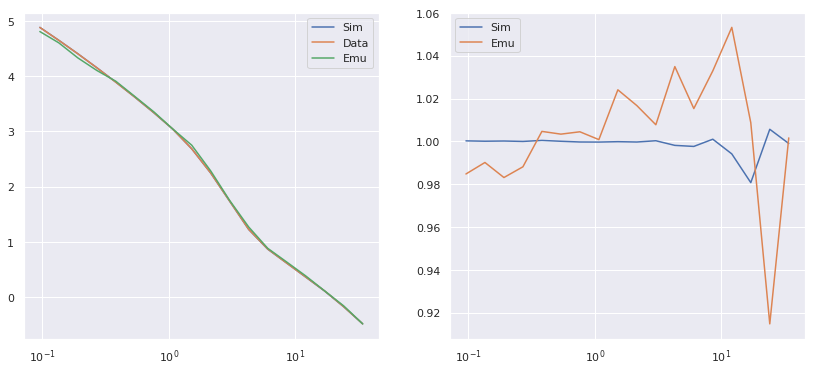

{'logM1': 13.856756756756756, 'logMmin': 13.334430260637397, 'alpha': 0.88728728728728734, 'logM0': 13.849249249249249, 'sigma_logM': 0.083283283283283285}


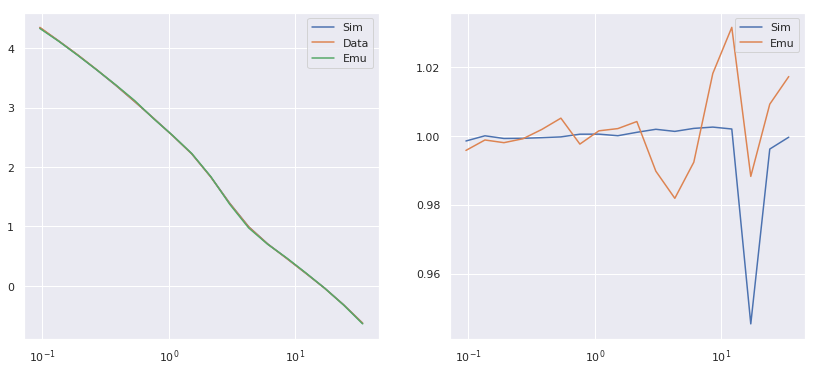

{'logM1': 13.955855855855855, 'logMmin': 13.410416984712004, 'alpha': 0.88528528528528527, 'logM0': 13.563963963963964, 'sigma_logM': 0.28623623623623623}


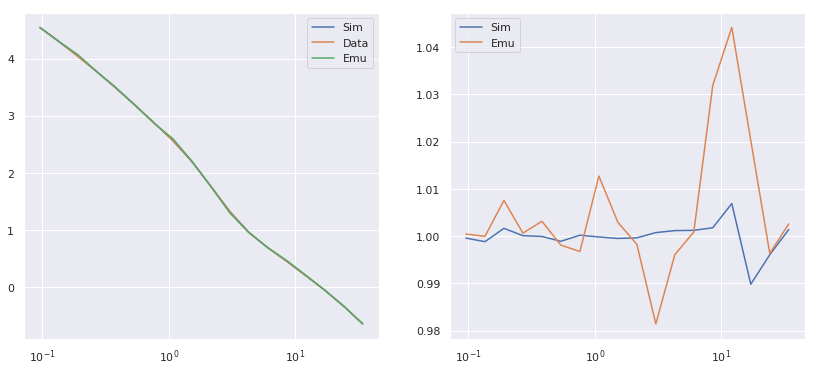

{'logM1': 14.173573573573574, 'logMmin': 13.276691990453521, 'alpha': 0.84244244244244249, 'logM0': 14.062462462462463, 'sigma_logM': 0.18413413413413415}


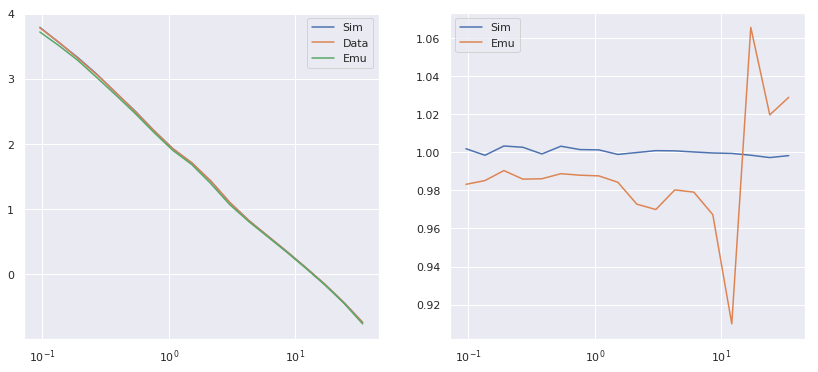

{'logM1': 13.379279279279279, 'logMmin': 15.999994031130429, 'alpha': 0.99099099099099097, 'logM0': 13.595495495495495, 'sigma_logM': 0.22542542542542543}


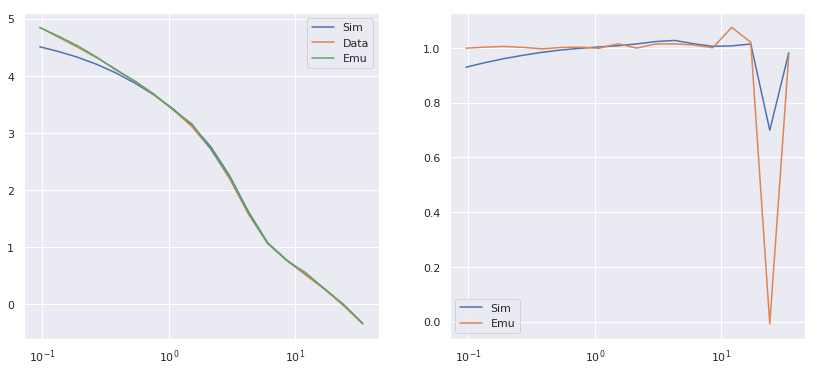

{'logM1': 13.353753753753754, 'logMmin': 13.760904874371564, 'alpha': 0.91491491491491495, 'logM0': 13.79069069069069, 'sigma_logM': 0.18188188188188187}


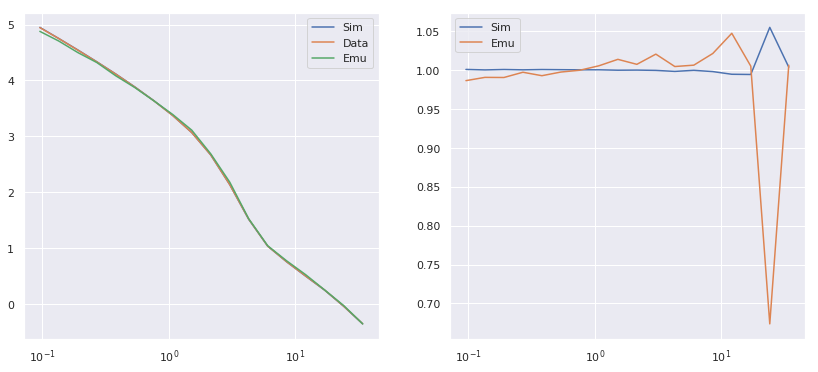

{'logM1': 14.32072072072072, 'logMmin': 13.275022564323582, 'alpha': 0.8456456456456457, 'logM0': 14.096996996996996, 'sigma_logM': 0.22467467467467467}


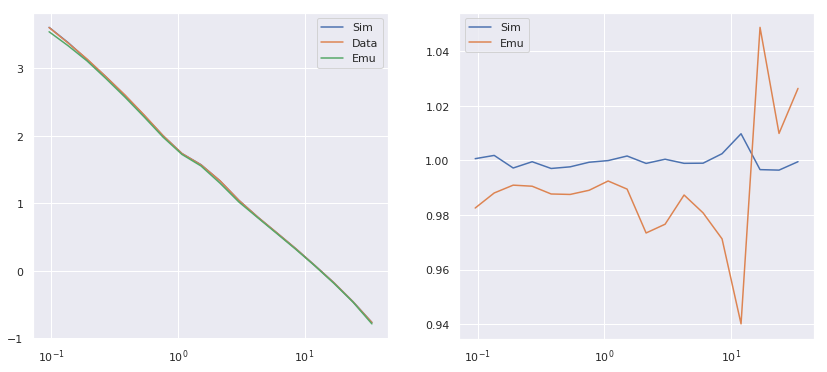

{'logM1': 13.966366366366366, 'logMmin': 13.27791724397091, 'alpha': 1.1039039039039038, 'logM0': 14.335735735735735, 'sigma_logM': 0.18363363363363361}


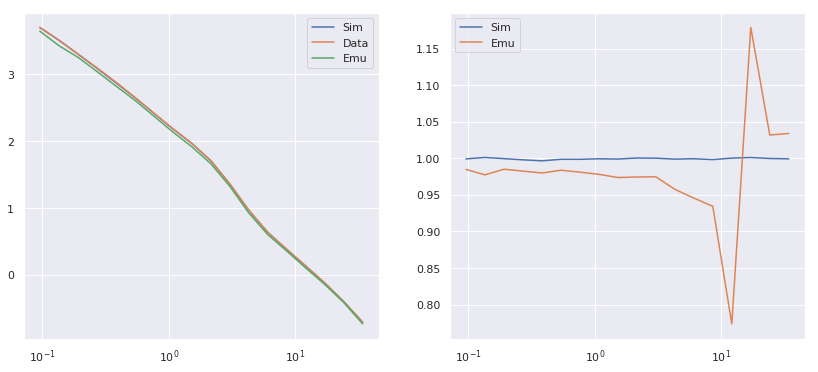

{'logM1': 14.002402402402403, 'logMmin': 13.453449094058429, 'alpha': 0.91011011011011012, 'logM0': 13.325225225225225, 'sigma_logM': 0.29249249249249248}


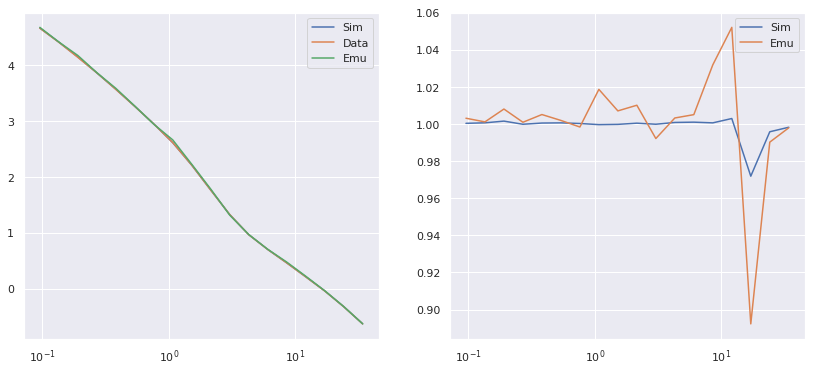

{'logM1': 13.754654654654654, 'logMmin': 13.279350297336279, 'alpha': 1.0714714714714715, 'logM0': 14.584984984984985, 'sigma_logM': 0.22992992992992994}


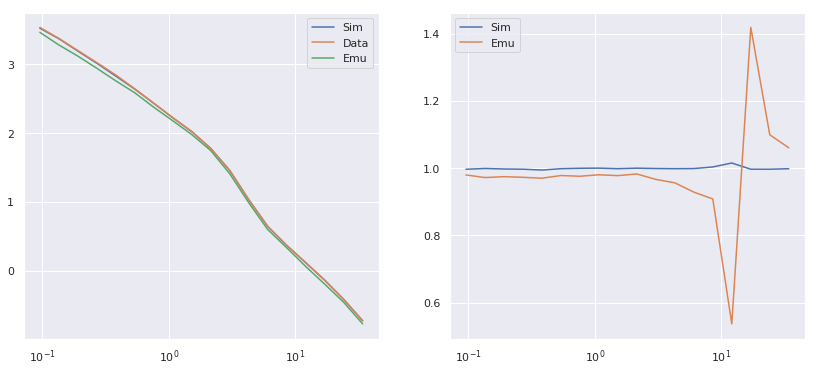

{'logM1': 13.191591591591591, 'logMmin': 13.400781234338254, 'alpha': 1.0478478478478479, 'logM0': 14.497897897897898, 'sigma_logM': 0.24019019019019017}


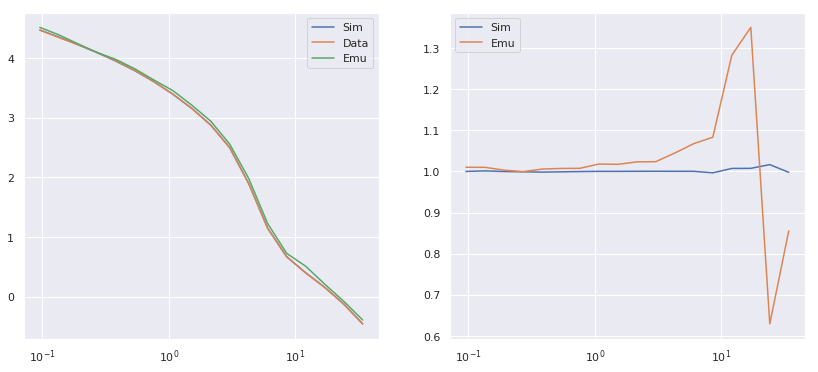

{'logM1': 14.18108108108108, 'logMmin': 13.329769848256065, 'alpha': 0.83323323323323328, 'logM0': 13.747147147147146, 'sigma_logM': 0.28423423423423422}


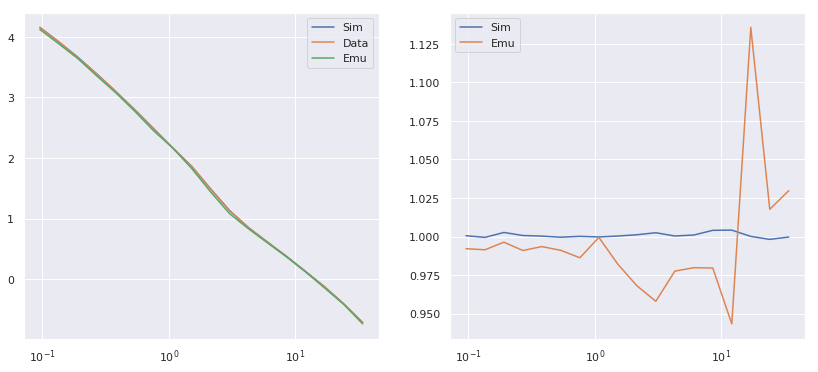

{'logM1': 13.897297297297296, 'logMmin': 13.426151571608457, 'alpha': 1.0766766766766767, 'logM0': 13.52042042042042, 'sigma_logM': 0.052252252252252253}


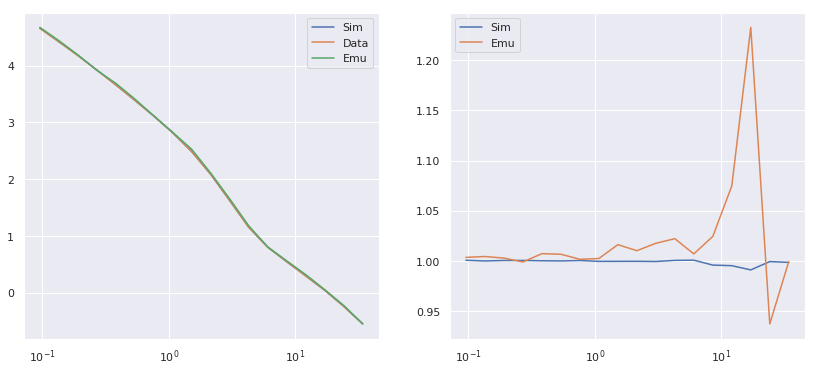

{'logM1': 13.314714714714714, 'logMmin': 15.99999608842716, 'alpha': 0.98858858858858856, 'logM0': 13.12102102102102, 'sigma_logM': 0.1581081081081081}


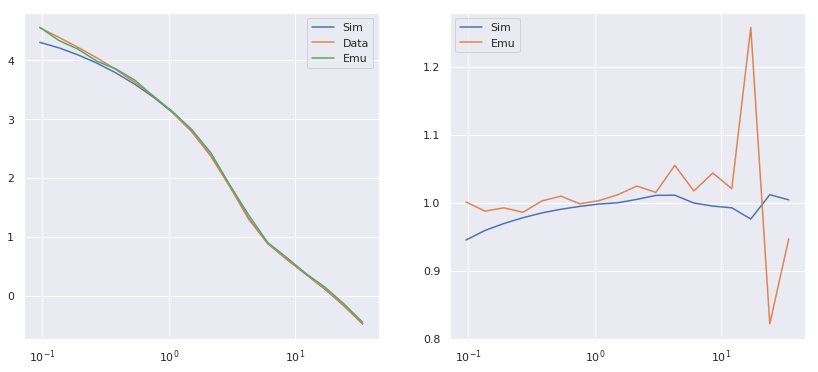

{'logM1': 14.52042042042042, 'logMmin': 13.250131952439522, 'alpha': 1.1115115115115115, 'logM0': 14.011411411411411, 'sigma_logM': 0.12032032032032032}


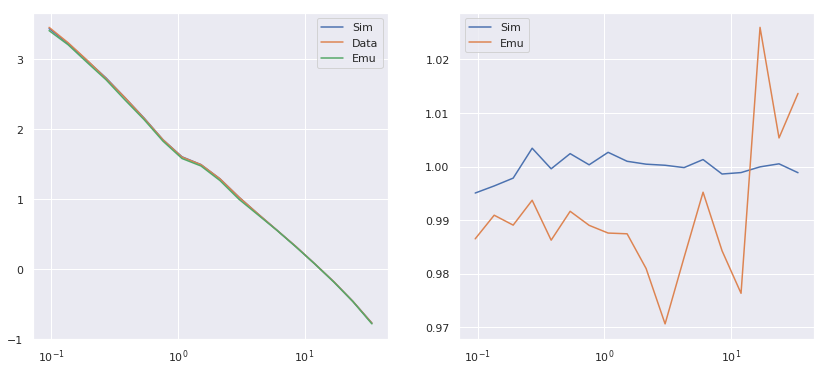

{'logM1': 13.527927927927928, 'logMmin': 13.602880659658489, 'alpha': 0.84324324324324329, 'logM0': 13.62102102102102, 'sigma_logM': 0.14134134134134135}


In [ ]:
for idx in xrange(100):
    x_point = train_x[idx*emu.n_bins, :-1]
    y_point = train_y[idx*emu.n_bins:(idx+1)*emu.n_bins]
    pop_params = dict(zip(info['ordered_params'].keys(), x_point))

    
    add_logMmin(pop_params, cat)
    print pop_params

    _xi_vals = []
    for i in xrange(10):
        cat.populate(pop_params, min_ptcl=100)
        _xi_vals.append(cat.calc_xi(r_bins))

    xi_vals = np.log10(np.array(_xi_vals))
    y_calc = xi_vals.mean(axis = 0)
    
    pop_params.update(cosmo_params)
    del pop_params['logMmin']
    
    y_pred = emu.emulate_wrt_r(pop_params)[0]

    fig = plt.figure(figsize = (14, 6))

    plt.subplot(121)
    plt.plot(rpoints, y_calc, label = 'Sim')
    plt.plot(rpoints, y_point, label = 'Data')
    plt.plot(rpoints, y_pred, label = 'Emu')
    plt.xscale('log')
    plt.legend(loc = 'best')
    plt.subplot(122)
    plt.plot(rpoints, y_calc/y_point, label = 'Sim')
    plt.plot(rpoints, y_pred/y_point, label = 'Emu')
    plt.legend(loc = 'best')

    plt.xscale('log')
    plt.show()